Dana Rozenblum & Efrat Magidov
# I. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [1]:
from sklearn.datasets import load_boston
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score

In [2]:
# Use the scikit-learn's DecisionTreeRegressor with max_depth = 1 (stumps) to write a L2Boost model which minimize the L2
# square loss iteration by iteration

class l2boost(BaseEstimator, TransformerMixin):
    
    def __init__(self,m_trees=100,eta=0.1,early_stop=False):
        self.m_trees=m_trees
        self.eta=eta
        self.trees=[]
        self.train_score=[]
        self.early_stop = early_stop

    def fit (self,X,y):
        self.mean=y.mean()
        f0=y.mean()*np.ones_like(y)
        fm=f0
        dt=DecisionTreeRegressor(max_depth=1)
        test_MSE = np.inf
        
        if self.early_stop:
            X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
            f0=y.mean()*np.ones_like(y)
            fm=f0
        
        for m in range(self.m_trees):
            m=m+1
            rm=y-fm
            dt=DecisionTreeRegressor(max_depth=1)
            dt.fit(X,rm)
            self.trees.append(dt)
            fm=fm+self.eta*dt.predict(X)
            self.train_score.append(self.mse_calc(fm,y))
            
            if self.early_stop:
                pred = self.predict(X_test)
                curr_MSE = mean_squared_error(y_test,pred)
                
                if curr_MSE > test_MSE:
                    self.trees.pop()
                    self.train_score.pop()
                    break
                   
                test_MSE = curr_MSE
        
        return self

    def predict(self,X):
        f0=self.mean*np.ones_like(X.shape[0])
        fm=f0
        
        for tree in self.trees:
            fm=fm+self.eta*tree.predict(X)
        
        return fm

    def predict_stage(self,X,y):
        f0=self.mean*np.ones_like(X.shape[0])
        fm=f0
        self.test_predictions=[]
        self.itterations_test_scores=[]
        
        for tree in self.trees:
            fm=fm+self.eta*tree.predict(X)
            self.test_predictions.append(fm)
            self.itterations_test_scores.append(self.mse_calc(fm,y))
        
        return fm

    def mse_calc(self,y_true, y_pred):
        return (np.sum((y_true-y_pred)**2)/y_true.shape[0])

    def score(self,X,y):
        y_p=self.predict(X)
        score=self.mse_calc(y_p,y)
        return score

n_trees: 1, CV_MSE: 89.88432
n_trees: 2, CV_MSE: 83.70087
n_trees: 4, CV_MSE: 74.10253
n_trees: 6, CV_MSE: 66.34747
n_trees: 8, CV_MSE: 59.05659
n_trees: 12, CV_MSE: 47.78267
n_trees: 18, CV_MSE: 38.73694
n_trees: 26, CV_MSE: 30.79152
n_trees: 37, CV_MSE: 27.22208
n_trees: 54, CV_MSE: 24.69527
n_trees: 78, CV_MSE: 23.89621
n_trees: 112, CV_MSE: 23.13651
n_trees: 162, CV_MSE: 22.59750
n_trees: 233, CV_MSE: 22.60609
n_trees: 335, CV_MSE: 23.07142
n_trees: 483, CV_MSE: 23.90143
n_trees: 695, CV_MSE: 24.73293
n_trees: 1000, CV_MSE: 25.76768



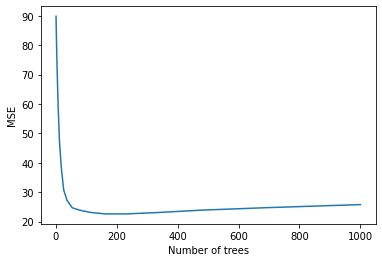

In [3]:
# Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of n_trees up to 1,000

np.random.seed(10)
X, y = load_boston(return_X_y=True)
MSEs = []
n_trees_list = np.unique(np.logspace(0,np.log2(1000), base=2, num=20).astype('int'))

for n_trees in n_trees_list:
    boost = l2boost(m_trees=n_trees)
    MSE = np.mean(-cross_val_score(boost, X, y, cv=5, scoring='neg_mean_squared_error'))
    MSEs.append(MSE)
    print(f'n_trees: {n_trees}, CV_MSE: {MSE:.5f}')
    
print('')

plt.plot(n_trees_list,MSEs)
plt.ylabel('MSE')
plt.xlabel('Number of trees')
plt.show()

In [4]:
# What is the optimal value of n_trees?

best_n_trees = n_trees_list[np.argmin(MSEs)]
min_MSE = np.min(MSEs)
print("The optimal value of n_trees is", best_n_trees)
print("MSE:", min_MSE)

The optimal value of n_trees is 162
MSE: 22.597504444470964


eta: 0.0, CV_MSE: 96.03278
eta: 0.1, CV_MSE: 22.60930
eta: 0.2, CV_MSE: 23.62643
eta: 0.3, CV_MSE: 25.22358
eta: 0.4, CV_MSE: 24.46316
eta: 0.5, CV_MSE: 25.96268
eta: 0.6, CV_MSE: 29.14606
eta: 0.7, CV_MSE: 29.43938
eta: 0.8, CV_MSE: 30.90797
eta: 0.9, CV_MSE: 33.21323
eta: 1.0, CV_MSE: 32.84882



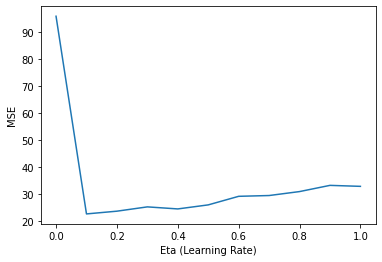

The optimal value of learning rate is 0.1
MSE: 22.609300042408215


In [5]:
# What is the optimal value of learning rate?

MSEs_for_eta = []
lr_list = np.arange(0,1.1,0.1)

for eta in lr_list:
    boost = l2boost(m_trees=best_n_trees, eta=eta)
    MSE_for_eta = np.mean(-cross_val_score(boost, X, y, cv=5, scoring='neg_mean_squared_error'))
    MSEs_for_eta.append(MSE_for_eta)
    print(f'eta: {eta:.1f}, CV_MSE: {MSE_for_eta:.5f}')
    
print('')

plt.plot(lr_list,MSEs_for_eta)
plt.ylabel('MSE')
plt.xlabel('Eta (Learning Rate)')
plt.show()

best_l_rate = lr_list[np.argmin(MSEs_for_eta)]
min_MSE_lr = np.min(MSEs_for_eta)
print("The optimal value of learning rate is", best_l_rate)
print("MSE:", min_MSE_lr)

max_depth: 1, MSE: 67.93741
max_depth: 2, MSE: 41.63263
max_depth: 3, MSE: 35.67237
max_depth: 4, MSE: 38.65875
max_depth: 5, MSE: 41.81539
max_depth: 6, MSE: 43.02075
max_depth: 7, MSE: 41.51690
max_depth: 8, MSE: 42.18661
max_depth: 9, MSE: 44.45593
max_depth: 10, MSE: 42.63673
max_depth: 11, MSE: 43.40391
max_depth: 12, MSE: 41.97607
max_depth: 13, MSE: 44.56109
max_depth: 14, MSE: 44.98847
max_depth: 15, MSE: 43.44071
max_depth: 16, MSE: 42.33465
max_depth: 17, MSE: 41.15861
max_depth: 18, MSE: 40.85469
max_depth: 19, MSE: 40.56448
max_depth: 20, MSE: 42.99411
max_depth: 21, MSE: 34.20337
max_depth: 22, MSE: 42.51293
max_depth: 23, MSE: 39.36076
max_depth: 24, MSE: 39.95412
max_depth: 25, MSE: 44.35926
max_depth: 26, MSE: 44.93973
max_depth: 27, MSE: 38.39926
max_depth: 28, MSE: 44.73190
max_depth: 29, MSE: 40.15230
max_depth: 30, MSE: 39.40694



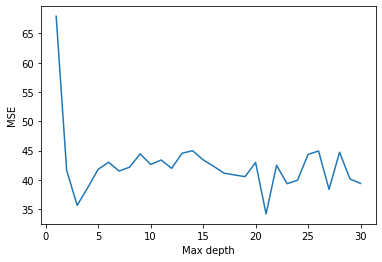

The optimal value of max_depth is 21
MSE: 34.20336594835954


In [6]:
# Compare the performance with a deep DecisionTreeRegressor

np.random.seed(10)
MSEs_depth = []
depth_list = np.arange(1,31,1)

for depth in depth_list:
    dtr = DecisionTreeRegressor(max_depth=depth)
    MSE_depth = np.mean(-cross_val_score(dtr, X, y, cv=5, scoring='neg_mean_squared_error'))
    MSEs_depth.append(MSE_depth)
    print(f'max_depth: {depth}, MSE: {MSE_depth:.5f}')
    
print('')

plt.plot(depth_list,MSEs_depth)
plt.ylabel('MSE')
plt.xlabel('Max depth')
plt.show()

best_depth = depth_list[np.argmin(MSEs_depth)]
min_MSE_dtr = np.min(MSEs_depth)
print("The optimal value of max_depth is", best_depth)
print("MSE:", min_MSE_dtr)

In [7]:
# Who wins?

if min_MSE_dtr < min_MSE_lr:
    print("DecisionTreeRegressor wins! It has a lower MSE")
    
else:
    print("L2Boost wins! It has a lower MSE")

L2Boost wins! It has a lower MSE


In [8]:
# Optional: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit

np.random.seed(11)
boost_es = l2boost(m_trees=best_n_trees, eta=eta, early_stop=True)
boost_es.fit(X, y)
print("Number of trees requested:",best_n_trees)
print("Number of trees used:",len(boost_es.trees))

Number of trees requested: 162
Number of trees used: 4


# II. AdaBoost From Scratch
# We did not cover this material during the lecture. Thus this part is optional, if time permits. Bonus (20 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


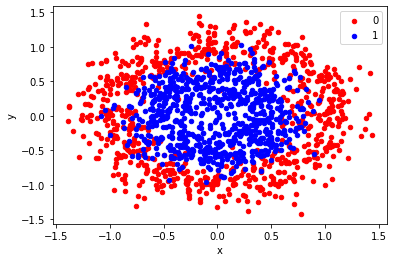

In [17]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [18]:
# Implement the AdaBoost algorithm for classification task

class AdaBoost:
    """ AdaBoost enemble classifier from scratch """

    def __init__(self,method="LinearSVC"):
        self.learners = None
        self.learner_weights = None
        self.errors = None
        self.sample_weights = None
        self.method = method
        self.n_samples = 20
        
    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y
    
    def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
        """ Fit the model using training data """

        X, y = self._check_X_y(X, y)
        n = X.shape[0]
        
        # for the first iteration, after each iteration we will resample by weight
        indices = np.random.choice(X.shape[0],self.n_samples)
        X_chosen = X[indices]
        y_chosen = y[indices]

        # init numpy arrays
        self.sample_weights = np.zeros(shape=(iters, n))
        self.learners = np.zeros(shape=iters, dtype=object)
        self.learner_weights = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)

        # initialize weights uniformly
        self.sample_weights[0] = np.ones(shape=n) / n

        for t in range(iters):
            # fit  weak learner
            curr_sample_weights = self.sample_weights[t]
            
            learner = None
            
            # LinearSVC is received at default when initializing
            if self.method == "LinearSVC":
                learner = LinearSVC()
            else:
                #learner = DecisionTreeClassifier(max_depth=1)
                print("Unknown method. Crushing. Bye")
            
            learner = learner.fit(X_chosen, y_chosen)

            # calculate error and learner weight from weak learner prediction
            learner_pred = learner.predict(X)
            err = curr_sample_weights[(learner_pred != y)].sum()# / n
            learner_weight = np.log((1 - err) / err) / 2

            # update sample weights
            new_sample_weights = (
                curr_sample_weights * np.exp(-learner_weight * y * learner_pred)
            )
        
            new_sample_weights /= new_sample_weights.sum()

            # If not final iteration, update sample weights for t+1
            if t+1 < iters:
                self.sample_weights[t+1] = new_sample_weights

            # save results of iteration
            self.learners[t] = learner
            self.learner_weights[t] = learner_weight
            self.errors[t] = err
            indices = learner_pred != y
            X_chosen = X[indices]
            indices = np.random.choice(X.shape[0],self.n_samples,p=new_sample_weights)
            X_chosen = X[indices]
            y_chosen = y[indices]

        return self

    def predict(self, X):
        """ Make predictions using already fitted model """
        learner_preds = np.array([learner.predict(X) for learner in self.learners])
        return np.sign(np.dot(self.learner_weights, learner_preds))

In [19]:
# Split the sample set into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train==0,-1,1) # our classifier needs 1 and -1 values
y_test = np.where(y_test==0,-1,1) # our classifier needs 1 and -1 values

Colored suraface is the decision plane
Points are the train data, colored by last iteration sample weights


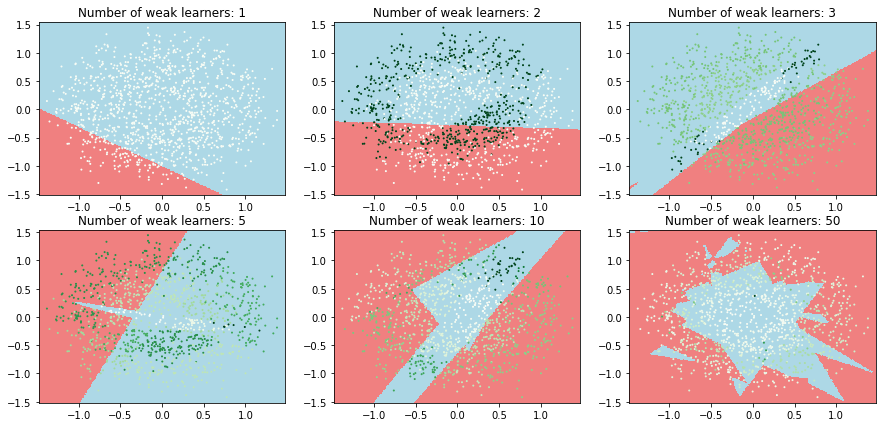

In [20]:
# Plot the final decision plane of your classifier for  𝑛∈{1,2,3,5,10,50} , and visualize the final iteration weights of the
# samples in those plots

np.random.seed(10)

plot_step = 0.01
class_names = "AB"

fig, axs = plt.subplots(2,3, figsize=(15, 7), facecolor='w', edgecolor='k')

n_weak_learners = [1,2,3,5,10,50]

print("Colored suraface is the decision plane")
print("Points are the train data, colored by last iteration sample weights")

for ax, n in zip(axs.ravel(),n_weak_learners):
    AdaLCSV = AdaBoost(method="LinearSVC")
    AdaLCSV.fit(X_train, y_train,iters=n)
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = AdaLCSV.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, colors=('lightcoral', 'lightblue'))
    ax.scatter(X_train[:, 0], X_train[:, 1], c=AdaLCSV.sample_weights[-1,:],s=1,cmap='Greens')
    ax.set_title(f'Number of weak learners: {n}')

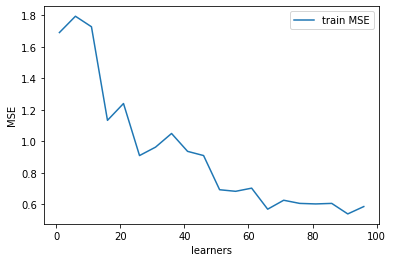

In general we can see that the overall train set accuracy improves as n is higher


In [21]:
# How does the overall train set accuracy changes with  𝑛 ?

np.random.seed(10)
MSEs_train = []
n_learners = np.arange(1,100,5)

for n in n_learners:
    ada = AdaBoost(method="LinearSVC")
    ada.fit(X_train, y_train,iters=n)
    y_pred_train = ada.predict(X_train)
    MSE_train = mean_squared_error(y_train,y_pred_train)
    MSEs_train.append(MSE_train)

plt.plot(n_learners,MSEs_train,label="train MSE")
plt.ylabel('MSE')
plt.xlabel('learners')
plt.legend()
plt.show()

print("In general we can see that the overall train set accuracy improves as n is higher")

Colored suraface is the decision plane
Points are the train data
For some of the runs we can spot some overfit for 500+ learners, but comparing to the test MSE we didn't absolutly find higher test error.


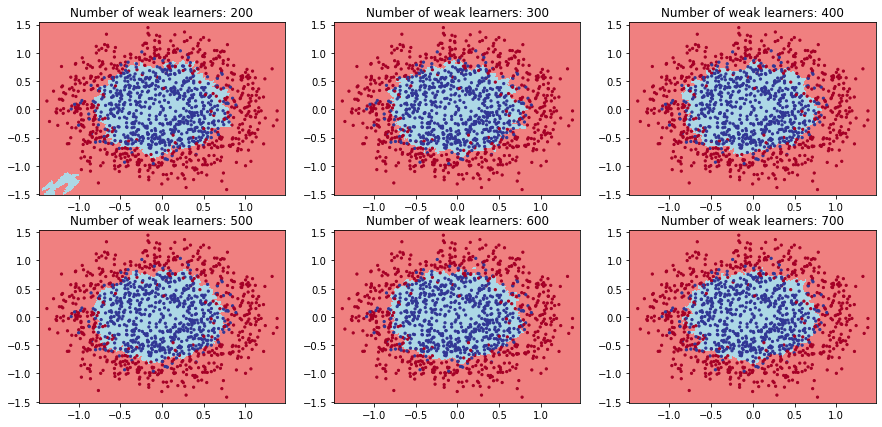

In [22]:
# Does you model starts to overfit at some point?

np.random.seed(10)

plot_step = 0.01
class_names = "AB"

fig, axs = plt.subplots(2,3, figsize=(15, 7), facecolor='w', edgecolor='k')

n_weak_learners = np.arange(200,800,100)

print("Colored suraface is the decision plane")
print("Points are the train data")
print("For some of the runs we can spot some overfit for 500+ learners, but comparing to the test MSE we didn't absolutly find higher test error.")

for ax, n in zip(axs.ravel(),n_weak_learners):
    AdaLCSV = AdaBoost(method="LinearSVC")
    AdaLCSV.fit(X_train, y_train,iters=n)
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = AdaLCSV.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, colors=('lightcoral', 'lightblue'))
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=5,cmap='RdYlBu')
    ax.set_title(f'Number of weak learners: {n}')

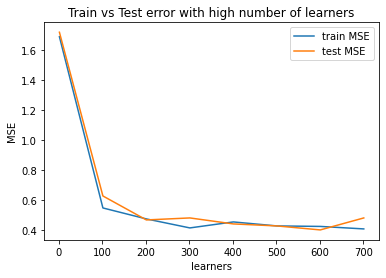

In [23]:
# Train vs Test error

np.random.seed(10)
MSEs_train = []
MSEs_test = []
n_weak_learners = np.arange(1,800,100)

for n in n_weak_learners:
    ada = AdaBoost(method="LinearSVC")
    ada.fit(X_train, y_train,iters=n)
    y_pred_train = ada.predict(X_train)
    MSE_train = mean_squared_error(y_train,y_pred_train)
    MSEs_train.append(MSE_train)
    y_pred_test = ada.predict(X_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    MSEs_test.append(MSE_test)

plt.plot(n_weak_learners,MSEs_train,label="train MSE")
plt.plot(n_weak_learners,MSEs_test,label="test MSE")
plt.ylabel('MSE')
plt.xlabel('learners')
plt.legend()
plt.title("Train vs Test error with high number of learners")
plt.show()